# Programmation linéaire en nombres entiers

In [1]:
using LinearAlgebra
using JuMP, Gurobi

Les logiciels commerciaux supportent, le plus souvent très efficacement, la programmation linéaire mixte en nombre entiers. Considérons par exemple le problème ci-dessous.

In [2]:
m = Model(with_optimizer(Gurobi.Optimizer))

# Variables
@variable(m, 0<= x1 <=10)
@variable(m, x2 >=0, Int)
@variable(m, x3, Bin)

# Fonction objectif
@objective(m, Max, x1 + 2x2 + 5x3)

# Contraintes
@constraint(m, constraint1, -x1 +  x2 + 3x3 <= -5)
@constraint(m, constraint2,  x1 + 3x2 - 7x3 <= 10)

# Modèle complet
print(m)

# Résoudre le problème
status = optimize!(m)

println("Optimal Solutions:")
println("x1 = ", value(x1), " x2 = ", value(x2), " x3 = ", value(x3))

Academic license - for non-commercial use only
Max x1 + 2 x2 + 5 x3
Subject to
 constraint1 : -x1 + x2 + 3 x3 <= -5.0
 constraint2 : x1 + 3 x2 - 7 x3 <= 10.0
 x1 >= 0.0
 x2 >= 0.0
 x1 <= 10.0
 x2 integer
 x3 binary
Academic license - for non-commercial use only
Optimize a model with 2 rows, 3 columns and 6 nonzeros
Variable types: 1 continuous, 2 integer (1 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+00]
  Objective range  [1e+00, 5e+00]
  Bounds range     [1e+01, 1e+01]
  RHS range        [5e+00, 1e+01]
Found heuristic solution: objective 19.0000000
Presolve removed 2 rows and 3 columns
Presolve time: 0.01s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 19 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.900000000000e+01, best bound 1.900000000000e+01, gap 0.0000%
Optimal Solutions:
x1 = 10.0 x2 = 2.0 x3 = 1.0


# Question 1

Soit le problème de programmation linéaire en nombres entiers suivant
\begin{align*}
\min\ z &= -10x_1 -20x_2 \\
\text{s.à } 
& 5x_1 + 8 x_2 \le 60 ,\\
&x_1 \le 8\\
&x_2 \le 4\\
& x_1,x_2 \ge 0 \text{ et entiers.}
\end{align*}

## Solution

Nous allons procéder par résolution graphique. Il est évidemment possible d'utiliser d'autres outils, comme des solveurs de programmation linéaire.

In [3]:
using Plots

## Itération 1

Nous commençons en résolvant la relaxation linéaire
\begin{align*}
\min\ z\ &= -10x_1 -20x_2 \\
\text{s.à } &
5x_1 + 8 x_2 \le 60\\
&x_1 \le 8\\
&x_2 \le 4\\
& x_1,x_2 \ge 0.
\end{align*}

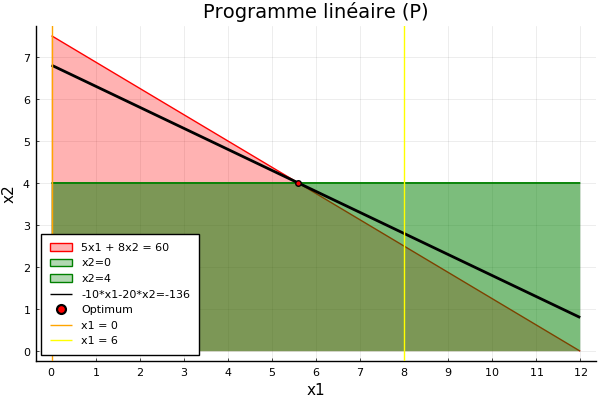

In [4]:
x1=0:0.01:12
g2 = (x1 -> 7-x1/2 ≥ 0 ? 15/2-5/8*x1 : NaN)
g3 = (x1 -> 0 )
g3 = (x1 -> 4 )

objOpt = (x1 -> -1/5*x1+(282.5)/50 ≥ 0 ? -1/2*x1+(136)/20 : NaN)

pyplot()

plot()

plot!(x1,g2,fillrange = 0,
         fillalpha = 0.3,
         fillcolor = :red,
         style=:auto,
         color=:red,
         label="5x1 + 8x2 = 60")
plot!(x1, g3,fillrange = 0,
         fillalpha = 0.3,
         fillcolor = :green,
         color=:green,
         label="x2=0")
plot!(x1, g3,fillrange = 0,
         fillalpha = 0.3,
         fillcolor = :green,
         color=:green,
         label="x2=4")

plot!(x1,objOpt, color=:black, linewidth=2, linestyle=:solid, label="-10*x1-20*x2=-136")


scatter!([5.6],[4],label="Optimum", color=:red)
vline!([0], label="x1 = 0", color=:orange)
vline!([8], label="x1 = 6", color=:yellow)

plot!(                                       
    #size=(800, 600),                                                                             
    xticks = 0:12,   
    yticks = 0:8,                          
                                                  
    ylabel = "x2", 
    xlabel = "x1",                       
    
    legend=:bottomleft,
    title  = "Programme linéaire (P)"                    
    )

Solution : $x_1 = 5.6$; $x_2 = 4$; $\bar{z} = -136$ 

## Itération 2

Nous branchons sur $x_1$ pour créer deux problèmes, le premier avec $x_1 \leq 5$, l'autre avec $x_1 \geq 6$.

Commençons par le premier problème
\begin{align*}
\min\ z\ &= -10x_1 -20x_2 \\
\text{s.à } &
5x_1 + 8 x_2 \le 60\\
&x_1 \le 5\\
&x_2 \le 4\\
& x_1, x_2 \ge 0.
\end{align*}

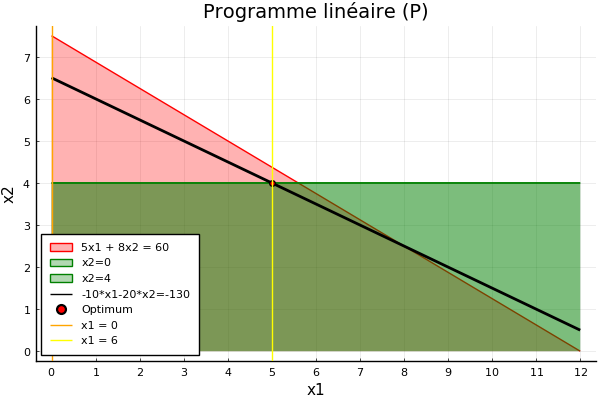

In [5]:
x1=0:0.01:12
g2 = (x1 -> 7-x1/2 ≥ 0 ? 15/2-5/8*x1 : NaN)
g3 = (x1 -> 0 )
g3 = (x1 -> 4 )

objOpt = (x1 -> -1/5*x1+(282.5)/50 ≥ 0 ? -1/2*x1+(130)/20 : NaN)

pyplot()

plot()

plot!(x1,g2,fillrange = 0,
         fillalpha = 0.3,
         fillcolor = :red,
         style=:auto,
         color=:red,
         label="5x1 + 8x2 = 60")
plot!(x1, g3,fillrange = 0,
         fillalpha = 0.3,
         fillcolor = :green,
         color=:green,
         label="x2=0")
plot!(x1, g3,fillrange = 0,
         fillalpha = 0.3,
         fillcolor = :green,
         color=:green,
         label="x2=4")

plot!(x1,objOpt, color=:black, linewidth=2, linestyle=:solid, label="-10*x1-20*x2=-130")


scatter!([5],[4],label="Optimum", color=:red)
vline!([0], label="x1 = 0", color=:orange)
vline!([5], label="x1 = 6", color=:yellow)

plot!(                                       
    #size=(800, 600),                                                                             
    xticks = 0:12,   
    yticks = 0:8,                          
                                                  
    ylabel = "x2", 
    xlabel = "x1",                       
    
    legend=:bottomleft,
    title  = "Programme linéaire (P)"                    
    )

Solution : $x_1 = 5$; $x_2 = 4$; $\bar{z} = -130$

La solution est entière, aussi nous ne devrons plus brancher à partir de ce sous-prblème, et nous avons une borne supérieure sur la valeur optimale.

## Itération 3

Considérons maintenant le problème
\begin{align*}
\min\ z\ &= -10x_1 -20x_2 \\
\text{s.à } &
5x_1 + 8 x_2 \le 60\\
&x_1 \le 8\\
&x_1 \ge 6\\
&x_2 \le 4\\
& x_1, x_2 \ge 0.
\end{align*}

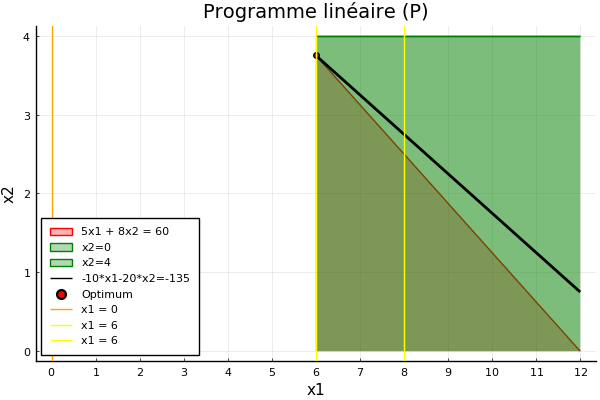

In [6]:
x1=6:0.01:12
g2 = (x1 -> 7-x1/2 ≥ 0 ? 15/2-5/8*x1 : NaN)
g3 = (x1 -> 0 )
g3 = (x1 -> 4 )


objOpt = (x1 -> -1/5*x1+(282.5)/50 ≥ 0 ? -1/2*x1+(135)/20 : NaN)

pyplot()

plot()

plot!(x1,g2,fillrange = 0,
         fillalpha = 0.3,
         fillcolor = :red,
         style=:auto,
         color=:red,
         label="5x1 + 8x2 = 60")
plot!(x1, g3,fillrange = 0,
         fillalpha = 0.3,
         fillcolor = :green,
         color=:green,
         label="x2=0")
plot!(x1, g3,fillrange = 0,
         fillalpha = 0.3,
         fillcolor = :green,
         color=:green,
         label="x2=4")

plot!(x1,objOpt, color=:black, linewidth=2, linestyle=:solid, label="-10*x1-20*x2=-135")


scatter!([6],[3.75],label="Optimum", color=:red)
vline!([0], label="x1 = 0", color=:orange)
vline!([6], label="x1 = 6", color=:yellow)
vline!([8], label="x1 = 6", color=:yellow)

plot!(                                       
    #size=(800, 600),                                                                             
    xticks = 0:12,   
    yticks = 0:8,                          
                                                  
    ylabel = "x2", 
    xlabel = "x1",                       
    
    legend=:bottomleft,
    title  = "Programme linéaire (P)"                    
    )

Solution : $x_1 = 6$; $x_2 = 3,75$; $\bar{z} = -135$

La solution n'est pas entière, et nous avons une borne inférieure sur la solution optimale au niveau des descendants du noeud courant. Comme cette borne est inférieure à la borne supérieure trouvée prédémment, il est possible de trouver une meilleure solution au problème initial en branchant à partir de ce noeud.

## Itération 4

Nous branchons à présent sur $x_2$, en considérant $x_2 \leq 3$ et $x_2 \geq 3$.

Le premier problème est
\begin{align*}
\min\ z\ &= -10x_1 -20x_2 \\
\text{s.à } &
5x_1 + 8 x_2 \le 60\\
&x_1 \le 8\\
&x_1 \ge 6\\
&x_2 \le 3\\
& x_1, x_2 \ge 0.
\end{align*}

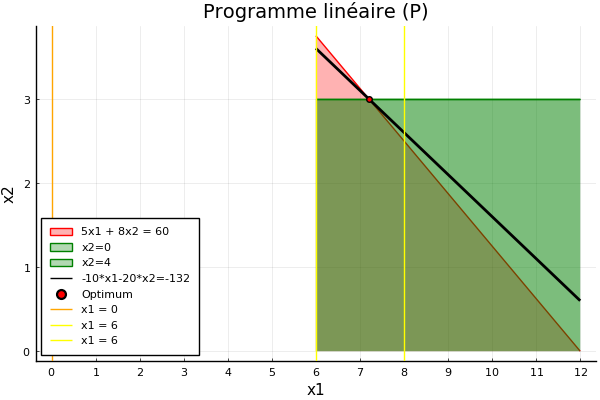

In [7]:
x1=6:0.01:12
g2 = (x1 -> 7-x1/2 ≥ 0 ? 15/2-5/8*x1 : NaN)
g3 = (x1 -> 0 )
g3 = (x1 -> 3 )


objOpt = (x1 -> -1/5*x1+(282.5)/50 ≥ 0 ? -1/2*x1+(132)/20 : NaN)

pyplot()

plot()

plot!(x1,g2,fillrange = 0,
         fillalpha = 0.3,
         fillcolor = :red,
         style=:auto,
         color=:red,
         label="5x1 + 8x2 = 60")
plot!(x1, g3,fillrange = 0,
         fillalpha = 0.3,
         fillcolor = :green,
         color=:green,
         label="x2=0")
plot!(x1, g3,fillrange = 0,
         fillalpha = 0.3,
         fillcolor = :green,
         color=:green,
         label="x2=4")

plot!(x1,objOpt, color=:black, linewidth=2, linestyle=:solid, label="-10*x1-20*x2=-132")


scatter!([7.2],[3],label="Optimum", color=:red)
vline!([0], label="x1 = 0", color=:orange)
vline!([6], label="x1 = 6", color=:yellow)
vline!([8], label="x1 = 6", color=:yellow)

plot!(                                       
    #size=(800, 600),                                                                             
    xticks = 0:12,   
    yticks = 0:8,                          
                                                  
    ylabel = "x2", 
    xlabel = "x1",                       
    
    legend=:bottomleft,
    title  = "Programme linéaire (P)"                    
    )

Solution : $x_1 = 7,2$; $x_2 = 3$; $\bar{z} = -132$

La solution n'est pas entière et la borne inférieure sur la valeur optimale à partir de ce noeud est -132, qui est plus basse que la meilleure borne supérieure connue, aussi nous ne pouvons pas élager le noeud à ce stade.

## Itération 5

Ce problème implique dès lors la création de deux nouveaux sous-problème, en branchant à nouveau sur $x_1$.

Considérons tout d'abord
\begin{align*}
\min\ z\ &= -10x_1 -20x_2 \\
\text{s.à } &
5x_1 + 8 x_2 \le 60\\
&x_1 \le 7\\
&x_1 \ge 6\\
&x_2 \le 3\\
& x_1, x_2 \ge 0.
\end{align*}

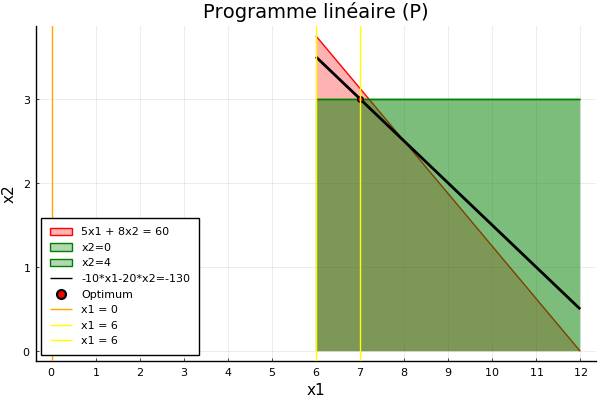

In [8]:
x1=6:0.01:12
g2 = (x1 -> 7-x1/2 ≥ 0 ? 15/2-5/8*x1 : NaN)
g3 = (x1 -> 0 )
g3 = (x1 -> 3 )


objOpt = (x1 -> -1/5*x1+(282.5)/50 ≥ 0 ? -1/2*x1+(130)/20 : NaN)

pyplot()

plot()

plot!(x1,g2,fillrange = 0,
         fillalpha = 0.3,
         fillcolor = :red,
         style=:auto,
         color=:red,
         label="5x1 + 8x2 = 60")
plot!(x1, g3,fillrange = 0,
         fillalpha = 0.3,
         fillcolor = :green,
         color=:green,
         label="x2=0")
plot!(x1, g3,fillrange = 0,
         fillalpha = 0.3,
         fillcolor = :green,
         color=:green,
         label="x2=4")

plot!(x1,objOpt, color=:black, linewidth=2, linestyle=:solid, label="-10*x1-20*x2=-130")


scatter!([7],[3],label="Optimum", color=:red)
vline!([0], label="x1 = 0", color=:orange)
vline!([6], label="x1 = 6", color=:yellow)
vline!([7], label="x1 = 6", color=:yellow)

plot!(                                       
    #size=(800, 600),                                                                             
    xticks = 0:12,   
    yticks = 0:8,                          
                                                  
    ylabel = "x2", 
    xlabel = "x1",                       
    
    legend=:bottomleft,
    title  = "Programme linéaire (P)"                    
    )

Solution : $x_1 = 7$; $x_2 = 3$; $\bar{z} = -130$

La solution est entière, pour une valeur objectif de -130, égale à la meilleure valeur actuellement connue.

## Itération 6

Le problème est maintenant
\begin{align*}
\min\ z\ &= -10x_1 -20x_2 \\
\text{s.à } &
5x_1 + 8 x_2 \le 60\\
&x_1 \ge 7\\
&x_1 \le 8\\
&x_2 \le 3\\
& x_1, x_2 \ge 0.
\end{align*}

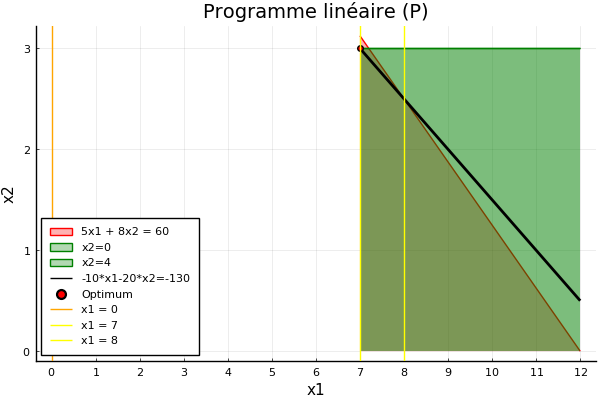

In [9]:
x1=7:0.01:12
g2 = (x1 -> 7-x1/2 ≥ 0 ? 15/2-5/8*x1 : NaN)
g3 = (x1 -> 0 )
g3 = (x1 -> 3 )


objOpt = (x1 -> -1/5*x1+(282.5)/50 ≥ 0 ? -1/2*x1+(130)/20 : NaN)

pyplot()

plot()

plot!(x1,g2,fillrange = 0,
         fillalpha = 0.3,
         fillcolor = :red,
         style=:auto,
         color=:red,
         label="5x1 + 8x2 = 60")
plot!(x1, g3,fillrange = 0,
         fillalpha = 0.3,
         fillcolor = :green,
         color=:green,
         label="x2=0")
plot!(x1, g3,fillrange = 0,
         fillalpha = 0.3,
         fillcolor = :green,
         color=:green,
         label="x2=4")

plot!(x1,objOpt, color=:black, linewidth=2, linestyle=:solid, label="-10*x1-20*x2=-130")


scatter!([7],[3],label="Optimum", color=:red)
vline!([0], label="x1 = 0", color=:orange)
vline!([7], label="x1 = 7", color=:yellow)
vline!([8], label="x1 = 8", color=:yellow)

plot!(                                       
    #size=(800, 600),                                                                             
    xticks = 0:12,   
    yticks = 0:8,                          
                                                  
    ylabel = "x2", 
    xlabel = "x1",                       
    
    legend=:bottomleft,
    title  = "Programme linéaire (P)"                    
    )

Solution :  𝑥1=8 ;  𝑥2=2,5 ;  𝑧¯=−130

La valeur n'est pas entière, mais la valeur de la fonction objectif associée à la solution du problème relaxé n'est pas meilleure que la meilleure valeur connue, aussi nous ne pourrons pas l'améliorer en branchant à partir du noeud actuel, aussi élaguons-nous le noeud.

## Itération 7

Nous devons revenir au noeud non-élagué avec la contrainte $x_2 \geq 4$.

En considérant les deux contraintes $x_2 \leq 4$ et $x_2 \geq 4$, nous voyons que $x_2$ doit être fixé à 4, et le problème se réécrit 
\begin{align*}
\min\ z\ &= -10x_1 - 80 \\
\text{s.à } & 5x_1 \le 28 \\
&x_1 \le 8\\
&x_1 \ge 6\\
& x_1 \ge 0.
\end{align*}
Mais $x_1$ ne peut être à la fois plus grand que 6 et plus petit que 28/5, aussi le problème est non-réalisable, et nous pouvons élaguer ce noeud.

Il n'y a plus de noeud à élaguer aussi non pouvons conclure. La valeur optimale est -130, atteinte en (5,4) et (7,3).

## Question 2

Source: http://web.tecnico.ulisboa.pt/mcasquilho/compute/_linpro/TaylorB_module_c.pdf

Le propriétaire d'un atelier d'usinage prévoit de se développer en achetant de nouvelles machines - des presses et des tours. Le propriétaire a estimé que chaque presse achetée augmenterait les bénéfices de \\$100 par jour et que chaque tour augmenterait les bénéfices de \\$150 par jour. Le nombre de machines que le propriétaire peut acheter est limité par le coût des machines et l'espace au sol disponible dans le magasin. Les prix d'achat des machines et les espaces requis sont présentés ci-dessous.

| Machine | Espace requis au sol ($pi^2$) | Prix d'achat |
| --- | --- | --- |
| Presse | 15 | \$8.000 |
| Tour | 30 | \$4.000 |

Le propriétaire dispose d'un budget de \$40.000 pour l'achat de machines et de 200 pieds carrés d'espace au sol disponible. Le propriétaire veut savoir combien de chaque type de machine acheter pour maximiser l'augmentation quotidienne des bénéfices.

Travaillons avec la relaxtion linéaire

In [10]:
m = Model(with_optimizer(Gurobi.Optimizer))

# Variables
@variable(m, x1 >= 0) # nombre de presses
@variable(m, x2 >= 0) # nombre de tours

# Fonction objectif
@objective(m, Max, 100x1 + 150x2)  # profit supplémentaire

# Contraintes
@constraint(m, constraint1, 8x1 +  4x2  <= 40)     # budget (en milliers de dollars)
@constraint(m, constraint2,  15x1 + 30x2  <= 200)  # contrainte d'espace

# Modèle complet
print(m)

# Résoudre le problème
status = optimize!(m)

Academic license - for non-commercial use only
Max 100 x1 + 150 x2
Subject to
 constraint1 : 8 x1 + 4 x2 <= 40.0
 constraint2 : 15 x1 + 30 x2 <= 200.0
 x1 >= 0.0
 x2 >= 0.0
Academic license - for non-commercial use only
Optimize a model with 2 rows, 2 columns and 4 nonzeros
Coefficient statistics:
  Matrix range     [4e+00, 3e+01]
  Objective range  [1e+02, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+01, 2e+02]
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.7500000e+31   3.125000e+30   8.750000e+01      0s
       2    1.0555556e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.00 seconds
Optimal objective  1.055555556e+03


In [11]:
obj = []

Any[]

In [12]:
function sol_output()
    if (termination_status(m) == MOI.INFEASIBLE)
        println("Problème non réalisable")

        append!(obj, -Inf)
    else
        println("Solution optimale:")
        println("x1 = ", value(x1), " x2 = ", value(x2))
        println("Valeur optimale = ", objective_value(m))
        
        # On va enregistrer les valeurs objectifs trouvées.
        append!(obj, objective_value(m))
    end
end

sol_output (generic function with 1 method)

In [13]:
sol_output()

Solution optimale:
x1 = 2.222222222222222 x2 = 5.555555555555556
Valeur optimale = 

1-element Array{Any,1}:
 1055.5555555555557

1055.5555555555557


La solution n'est pas entière.

On va brancher sur la plus grande valeur fractionnaire, ici $x_2$.

In [14]:
@constraint(m, x2left, x2 <= 5)

# Modèle complet
print(m)

# Résoudre le problème
status = optimize!(m)

sol_output()

Max 100 x1 + 150 x2
Subject to
 constraint1 : 8 x1 + 4 x2 <= 40.0
 constraint2 : 15 x1 + 30 x2 <= 200.0
 x2left : x2 <= 5.0
 x1 >= 0.0
 x2 >= 0.0
Optimize a model with 3 rows, 2 columns and 5 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [1e+02, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 2e+02]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0555556e+03   2.222222e+00   0.000000e+00      0s
       1    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.00 seconds
Optimal objective  1.000000000e+03
Solution optimale:
x1 = 2.5 x2 = 5.0
Valeur optimale = 1000.0


2-element Array{Any,1}:
 1055.5555555555557
 1000.0

In [15]:
delete(m, x2left)
@constraint(m, x2right, x2 >= 6)

# Modèle complet
print(m)

# Résoudre le problème
status = optimize!(m)

sol_output()

Max 100 x1 + 150 x2
Subject to
 x2right : x2 >= 6.0
 constraint1 : 8 x1 + 4 x2 <= 40.0
 constraint2 : 15 x1 + 30 x2 <= 200.0
 x1 >= 0.0
 x2 >= 0.0
Optimize a model with 3 rows, 2 columns and 5 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [1e+02, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+00, 2e+02]
Presolve removed 3 rows and 2 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
       0    1.0333333e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.033333333e+03
Solution optimale:
x1 = 1.3333333333333333 x2 = 6.0
Valeur optimale = 1033.3333333333333


3-element Array{Any,1}:
 1055.5555555555557
 1000.0
 1033.3333333333333

In [16]:
using LightGraphs
using GraphPlot

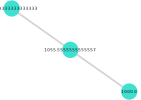

In [17]:
g = Graph()
add_vertices!(g,3)
add_edge!(g, 1, 2)
add_edge!(g, 1, 3)
gplot(g, nodelabel=obj)

Pour $x_2 \leq 5$, la borne supérieure sur la fonction objectif est de 1000, mais la solution n'est pas entière.

Pour $x_2 \geq 6$, la borne supérieure sur la fonction objectif est de 1033+1/3, mais la solution n'est pas non plus entière.

Nous allons brancher à partir de la plus grande borne supérieure. Comme la solution optimale du problème relâxé est $x_1 = 4/3$ et $x2 = 6.0$, nous devons brancher sur $x_1$.

In [18]:
@constraint(m, x1left, x1 <= 1)

# Modèle complet
print(m)

# Résoudre le problème
status = optimize!(m)

sol_output()

Max 100 x1 + 150 x2
Subject to
 x2right : x2 >= 6.0
 constraint1 : 8 x1 + 4 x2 <= 40.0
 constraint2 : 15 x1 + 30 x2 <= 200.0
 x1left : x1 <= 1.0
 x1 >= 0.0
 x2 >= 0.0
Optimize a model with 4 rows, 2 columns and 6 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [1e+02, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+02]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0333333e+03   6.666667e-01   0.000000e+00      0s
       1    1.0250000e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.00 seconds
Optimal objective  1.025000000e+03
Solution optimale:
x1 = 1.0 x2 = 6.166666666666667
Valeur optimale = 1025.0

4-element Array{Any,1}:
 1055.5555555555557
 1000.0
 1033.3333333333333
 1025.0

In [19]:
delete(m, x1left)
@constraint(m, x1right, x1 >= 2)

# Modèle complet
print(m)

# Résoudre le problème
status = optimize!(m)

sol_output()

Max 100 x1 + 150 x2
Subject to
 x2right : x2 >= 6.0
 x1right : x1 >= 2.0
 constraint1 : 8 x1 + 4 x2 <= 40.0
 constraint2 : 15 x1 + 30 x2 <= 200.0
 x1 >= 0.0
 x2 >= 0.0
Optimize a model with 4 rows, 2 columns and 6 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [1e+02, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 2e+02]
Presolve removed 3 rows and 2 columns
Presolve time: 0.00s

Solved in 0 iterations and 0.00 seconds
Infeasible or unbounded model
Solution optimale:

LoadError: Result index of attribute MathOptInterface.VariablePrimal(1) out of bounds. There are currently 0 solution(s) in the model.

En ajoutant la contrainte $x_1 \geq 2$, le problème est non réalisable. Nous ne pouvons donc plus brancher de ce côté. Avec $x_1 \leq 1.0$, la solution n'est toujours pas entière. Nous allons brancher sur $x_2$ qui demeure fractionnaire.

Nous enregistrons la valeur Inf pour représenter l'infaisabilité.

In [20]:
obj = vcat(obj, Inf)

5-element Array{Any,1}:
 1055.5555555555557
 1000.0
 1033.3333333333333
 1025.0
   Inf

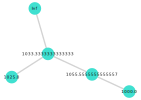

In [21]:
g = Graph()
add_vertices!(g,5)
add_edge!(g, 1, 2)
add_edge!(g, 1, 3)
add_edge!(g, 3, 4)
add_edge!(g, 3, 5)
gplot(g, nodelabel = obj)

Branchons sur $x_2$.

In [22]:
delete(m, x1right)
@constraint(m, x1left1, x1 <= 1)
@constraint(m, x2left6, x2 <= 6)

# Modèle complet
print(m)

# Résoudre le problème
status = optimize!(m)

sol_output()

Max 100 x1 + 150 x2
Subject to
 x2right : x2 >= 6.0
 constraint1 : 8 x1 + 4 x2 <= 40.0
 constraint2 : 15 x1 + 30 x2 <= 200.0
 x1left1 : x1 <= 1.0
 x2left6 : x2 <= 6.0
 x1 >= 0.0
 x2 >= 0.0
Optimize a model with 5 rows, 2 columns and 7 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [1e+02, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+02]
Presolve removed 5 rows and 2 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000000000e+03
Solution optimale:
x1 = 1.0 x2 = 6.0
Valeur optimale = 1000.0


6-element Array{Any,1}:
 1055.5555555555557
 1000.0
 1033.3333333333333
 1025.0
   Inf
 1000.0

La solution est à présent entière, aussi nous obtenons une borne inférieure sur la valeur optimale, et nous élaguons le noeud comme nous ne pouvons plus brancher dessus.

L'autre branche consiste à examiner le cas où $x_2 \geq 7$.

In [23]:
delete(m, x2left6)
@constraint(m, x2right7, x2 >= 7)

# Modèle complet
print(m)

# Résoudre le problème
status = optimize!(m)

sol_output()

Max 100 x1 + 150 x2
Subject to
 x2right : x2 >= 6.0
 x2right7 : x2 >= 7.0
 constraint1 : 8 x1 + 4 x2 <= 40.0
 constraint2 : 15 x1 + 30 x2 <= 200.0
 x1left1 : x1 <= 1.0
 x1 >= 0.0
 x2 >= 0.0
Optimize a model with 5 rows, 2 columns and 7 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [1e+02, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+02]
Presolve removed 3 rows and 0 columns
Presolve time: 0.00s

Solved in 0 iterations and 0.00 seconds
Infeasible or unbounded model
Solution optimale:

LoadError: Result index of attribute MathOptInterface.VariablePrimal(1) out of bounds. There are currently 0 solution(s) in the model.

Le problème est non-réalisable. Nous pouvons élaguer le noeud.

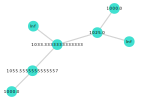

In [24]:
obj = vcat(obj, Inf)

g = Graph()
add_vertices!(g,7)
add_edge!(g, 1, 2)
add_edge!(g, 1, 3)
add_edge!(g, 3, 4)
add_edge!(g, 3, 5)
add_edge!(g, 4, 6)
add_edge!(g, 4, 7)
gplot(g, nodelabel=obj)

Nous 

Retournons au noeud non élagué avec $x_2 \leq 5$. Dans ce cas la borne supérieure sur la fonction objectif est de 1000, qui est la valeur trouvée précédemment avec la solution entière $x_1 = 1$, $x_2 = 6$. Nous ne pouvons donc pas améliorer l'objectif en explorant le cas $x_2 <= 5$ et nous élaguons le noeud correspondant. Comme il n'y a plus de noeud non élagué, nous nous arrêtons avec la solution optimale $x_1 = 1$, $x_2 = 6$.

## Méthode de coupes

Considérons le problème
\begin{align*}
\min\ & -21x_1 - 11x_2 \\
\text{sujet à } & 7x_1 + 4x_2 + x_3 = 13 \\
& x_1 \geq 0, x_2 \geq 0, x_3 \geq 0 \\
& x_1, x_2, x_3 \text{ entiers.}
\end{align*}
Nous allons tout d'abord le modélier à l'aide de JuMP, puis utiliser la méthode de coupes.

Nous reformulons le problème dans la modélisation JuMP en tenant compte de ses caractéristiques.

In [25]:
m = Model(with_optimizer(Gurobi.Optimizer))

# Variables
@variable(m, x1 >=0, Int)
@variable(m, x2 >=0, Int)

# Fonction objectif
@objective(m, Max, 21x1 + 11x2)

# Contraintes
@constraint(m, constraint1, 7x1 +  4x2 <= 13)

# Modèle complet
print(m)

# Résoudre le problème
status = optimize!(m)

println("Optimal solution:")
println("x1 = ", value(x1), " x2 = ", value(x2))

Academic license - for non-commercial use only
Max 21 x1 + 11 x2
Subject to
 constraint1 : 7 x1 + 4 x2 <= 13.0
 x1 >= 0.0
 x2 >= 0.0
 x1 integer
 x2 integer
Academic license - for non-commercial use only
Optimize a model with 1 rows, 2 columns and 2 nonzeros
Variable types: 0 continuous, 2 integer (0 binary)
Coefficient statistics:
  Matrix range     [4e+00, 7e+00]
  Objective range  [1e+01, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 1e+01]
Found heuristic solution: objective 32.0000000
Presolve removed 1 rows and 2 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds
Thread count was 1 (of 8 available processors)

Solution count 2: 33 32 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.300000000000e+01, best bound 3.300000000000e+01, gap 0.0000%
Optimal solution:
x1 = -0.0 x2 = 3.0


Résolvons la relaxation linéaire avec la méthode du simplexe primal.

Écrivons le tableau initial
$$
\begin{array}{c|ccc|c}
    & x_1 & x_2 & x_3 & b \\
    \hline
    x_3 & 7 & 4 & 1 & 13 \\
    \hline
    & -21 & -11 & 0 & 0
\end{array}
$$
Le système est déjà sous forme canonique ($x_3$ peut être vu comme variable d'écart). En choisissant le coût le plus négatif, nous échangeons $x_1$ et $x_3$ pour obtenir le tableau
$$
\begin{array}{c|ccc|c}
    & x_1 & x_2 & x_3 & b \\
    \hline
    x_1 & 1 & 4/7 & 1/7 & 13/7 \\
    \hline
    & 0 & 1 & 3 & -39
\end{array}
$$
Tous les coûts réduits sont non-négatifs et donc la solution est optimale, mais ne satisfait pas les conditions d'intégralité.


Nous ajoutons la contrainte
$$
\left( \left\lfloor \frac{4}{7} \right\rfloor - \frac{4}{7} \right) x_2 + \left( \left\lfloor \frac{1}{7} \right\rfloor - \frac{1}{7} \right) x_3 \leq \left\lfloor \frac{13}{7} \right\rfloor - \frac{13}{7},
$$
ou de manière équivalente
$$
 - \frac{4}{7} x_2 - \frac{1}{7} x_3 + x_4 = -\frac{6}{7},
$$
avec $x_4 \geq 0$, $x_4$ entier.
Le problème devient
\begin{align*}
\min\ & -21x_1 - 11x_2 \\
\text{sujet à } & 7x_1 + 4x_2 + x_3 = 13 \\
& - \frac{4}{7} x_2 - \frac{1}{7} x_3 + x_4 = -\frac{6}{7} \\
& x_1 \geq 0, x_2 \geq 0, x_3 \geq 0, x_4 \geq 0 \\
& x_1, x_2, x_3, x_4 \text{ entiers.}
\end{align*}
Nous pardons du tableau précédent pour obtenir le tableau du simplexe du problème relaxé linéairement
$$
\begin{array}{c|cccc|c}
    & x_1 & x_2 & x_3 & x_4 & b \\
    \hline
    x_1 & 1 & 4/7 & 1/7 & 0 & 13/7 \\
    x_4 & 0 & -4/7 & -1/7 & 1 & -6/7 \\
    \hline
    & 0 & 1 & 3 & 0 & 39
\end{array}
$$
Les conditions d'optimalité sont satisfaites, mais pas de faisabilité, aussi nous exécutons une itération du simplexe dual pour rétablir la faisabilité.

Nous échangeons $x_2$ et $x_4$ pour obtenir
$$
\begin{array}{c|cccc|c}
    & x_1 & x_2 & x_3 & x_4 & b \\
    \hline
    x_1 & 1 & 0 & 0 & 1 & 1 \\
    x_2 & 0 & 1 & 1/4 & -7/4 & 3/2 \\
    \hline
    & 0 & 0 & 11/4 & 7/4 & 37.5
\end{array}
$$
La solution est à présent réalisable et optimale, mais $x_2$ est à présent fractionnaire, et nous allons construire une nouvelle coupe, en considérant l'inégalité
$$
\left( \left\lfloor \frac{1}{4} \right\rfloor - \frac{1}{4} \right) x_3 + \left( \left\lfloor \frac{-7}{4} \right\rfloor + \frac{7}{4} \right) x_4 \leq \left\lfloor \frac{3}{2} \right\rfloor - \frac{3}{2},
$$
ou de manière équivalente
$$
 - \frac{1}{4} x_3 - \frac{1}{4} x_4 + x_5 = -\frac{1}{2},
$$
avec $x_5 \geq 0$, $x_5$ entier.
Nous ajoutons cette contrainte et à nouveau effectuons une itération du simplexe dual pour rétablir la faisabilité. Nous partons du tableau
$$
\begin{array}{c|ccccc|c}
    & x_1 & x_2 & x_3 & x_4 & x_5 & b \\
    \hline
    x_1 & 1 & 0 & 0 & 1 & 0 & 1 \\
    x_2 & 0 & 1 & 1/4 & -7/4 & 0 & 3/2 \\
    x_5 & 0 & 0 & -1/4 & -1/4 & 1 & -1/2 \\
    \hline
    & 0 & 0 & 11/4 & 7/4 & 0 & 37.5
\end{array}
$$


Nous échangeon $x_4$ et $x_5$ pour aboutir au tableau
$$
\begin{array}{c|ccccc|c}
    & x_1 & x_2 & x_3 & x_4 & x_5 & b \\
    \hline
    x_1 & 1 & 0 & -1 & 0 & 4 & -1 \\
    x_2 & 0 & 1 & 2 & 0 & -7 & 5 \\
    x_5 & 0 & 0 & 1 & 1 & -4 & 2 \\
    \hline
    & 0 & 0 & 1 & 0 & 7 & 34
\end{array}
$$
Nous voyons que la solution est entière, mais toujours non réalisable, et nous avons une itération duale supplémentaire à effectuer.
$$
\begin{array}{c|ccccc|c}
    & x_1 & x_2 & x_3 & x_4 & x_5 & b \\
    \hline
    x_3 & -1 & 0 & 1 & 0 & -4 & 1 \\
    x_2 & 2 & 1 & 0 & 0 & 1 & 3 \\
    x_5 & 1 & 0 & 0 & 1 & 0 & 1 \\
    \hline
    & 1 & 0 & 0 & 0 & 11 & 33
\end{array}
$$
La solution est à présent réalisable, entière, et les conditions d'optimalité remplies. Nous avons finalement convergé!

La solution optimale est donc $x_1 = 0$, $x_2 = 3$, pour une valeur optimale de -33, ce qui est conforme à la solution fournie par Gurobi.